In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'absolute'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_distilbert_ABOUT_abs_adam'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5829288205618642 	 Validation loss: 0.4189222500485889 	 
  1%|          | 574/57400 [02:16<3:21:57,  4.69it/s]
Epoch 2 	 Training loss: 0.3893555954150622 	 Validation loss: 0.35908600940542706 	 
  2%|▏         | 1148/57400 [04:26<3:23:30,  4.61it/s]
Epoch 3 	 Training loss: 0.35137445126572553 	 Validation loss: 0.34196518664642916 	 
  3%|▎         | 1722/57400 [06:36<3:33:18,  4.35it/s]
Epoch 4 	 Training loss: 0.33367410681181253 	 Validation loss: 0.33268792447397266 	 
  4%|▍         | 2296/57400 [08:47<3:22:58,  4.52it/s]
Epoch 5 	 Training loss: 0.31805206894978416 	 Validation loss: 0.32715679604118153 	 
  5%|▌         | 2870/57400 [10:57<2:43:52,  5.55it/s]
Epoch 6 	 Training loss: 0.30927627546654346 	 Validation loss: 0.32154180058988474 	 
  6%|▌         | 3444/57400 [13:06<3:17:51,  4.55it/s]
Epoch 7 	 Training loss: 0.29914055126053946 	 Validation loss: 0.31680444287041487 	 
  7%|▋         | 4018/57400 [15:16<3:15:10,  4.56it/s]
Epoch 8 	 

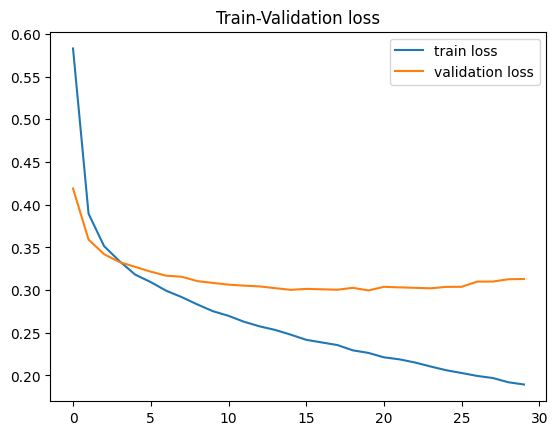

In [16]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [17]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8418367346938775
MALE 0.8463541666666666
FEMALE 0.8375 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6691919191919192
MALE 0.681265206812652
FEMALE 0.6561679790026247 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6779661016949152
MALE 0.6540404040404041
FEMALE 0.7035040431266847 



# TO

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_distilbert_TO_abs_adam'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6975706387895325 	 Validation loss: 0.692826854980598 	 
  1%|          | 574/57400 [02:10<3:34:56,  4.41it/s]
Epoch 2 	 Training loss: 0.6948234065069139 	 Validation loss: 0.6942414116051238 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:20<3:24:39,  4.58it/s]
Epoch 3 	 Training loss: 0.6949104878545223 	 Validation loss: 0.6936409018807492 	 
  3%|▎         | 1722/57400 [06:28<3:16:57,  4.71it/s]
Epoch 4 	 Training loss: 0.6942410201145797 	 Validation loss: 0.6929583236322565 	 
  4%|▍         | 2296/57400 [08:38<3:15:19,  4.70it/s]
Epoch 5 	 Training loss: 0.6942205277469515 	 Validation loss: 0.6930842945131205 	 
  5%|▌         | 2870/57400 [10:48<3:21:37,  4.51it/s]
Epoch 6 	 Training loss: 0.6939833810105142 	 Validation loss: 0.6941055433224823 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [12:58<3:18:33,  4.53it/s]
Epoch 7 	 Training loss: 0.6940453192705892 	 Validation loss: 0.6931649436384945 	 
  7%|▋         | 40

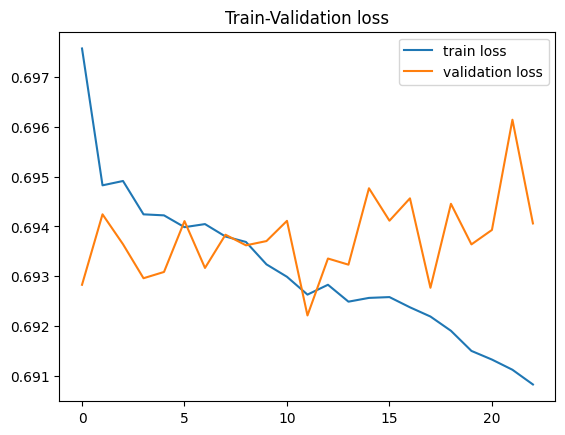

In [19]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5395408163265306
MALE 0.3411458333333333
FEMALE 0.73 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5757575757575758
MALE 0.44282238442822386
FEMALE 0.7191601049868767 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5814863102998696
MALE 0.4166666666666667
FEMALE 0.7574123989218329 



# AS

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_distilbert_AS_abs_adam'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6961242669758481 	 Validation loss: 0.6922060170416104 	 
  1%|          | 574/57400 [02:05<2:45:24,  5.73it/s]
Epoch 2 	 Training loss: 0.6948146462855854 	 Validation loss: 0.6942509533995289 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:10<3:18:37,  4.72it/s]
Epoch 3 	 Training loss: 0.6935575797582753 	 Validation loss: 0.69336672758652 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [06:15<3:15:04,  4.76it/s]
Epoch 4 	 Training loss: 0.6926093120192817 	 Validation loss: 0.6939574015342583 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [08:19<3:07:38,  4.89it/s]
Epoch 5 	 Training loss: 0.6903742150977928 	 Validation loss: 0.6918115535024869 	 
  5%|▌         | 2870/57400 [10:25<3:15:53,  4.64it/s]
Epoch 6 	 Training loss: 0.6892812670523282 	 Validation loss: 0.6928239878961595 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [12:35<3:24:33,  4.40it/s]
Epoch 7 	 Training loss: 0.6879294073332477 	 V

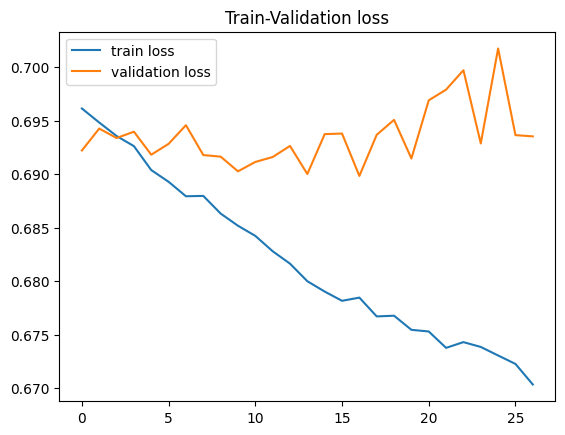

In [22]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [23]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.6288265306122449
MALE 0.546875
FEMALE 0.7075 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6818181818181818
MALE 0.6204379562043796
FEMALE 0.7480314960629921 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.7001303780964798
MALE 0.6035353535353535
FEMALE 0.8032345013477089 

